In [4]:
import numpy as np
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt
import os



In [6]:
import cv2
import string
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks

In [7]:
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [8]:
print(num_symbols)

36


In [13]:
def preprocess_data():
    n_samples = len(os.listdir('./captcha_dataset/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('./captcha_dataset/samples')):
    
        img = cv2.imread(os.path.join('./captcha_dataset/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
    
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
    
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]


In [28]:
X_train.shape

(970, 50, 200, 1)

In [15]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model


In [16]:
model=create_model();
model.summary();


2024-04-02 17:24:08.327550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 17:24:08.616291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 17:24:08.616482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 200, 16)          160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 25, 100, 16)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d[0][0]']   

In [17]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)


Epoch 1/30


2024-04-02 17:24:26.765407: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-04-02 17:24:28.606841: I external/local_xla/xla/service/service.cc:168] XLA service 0x7dd3bc1eac70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-02 17:24:28.606872: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P1000, Compute Capability 6.1
2024-04-02 17:24:28.625192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712058868.740123  121059 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 8s 85ms/step - loss: 18.0783 - dense_1_loss: 3.4738 - dense_3_loss: 3.6840 - dense_5_loss: 3.6205 - dense_7_loss: 3.6585 - dense_9_loss: 3.6415 - dense_1_accuracy: 0.0670 - dense_3_accuracy: 0.0657 - dense_5_accuracy: 0.0554 - dense_7_accuracy: 0.0528 - dense_9_accuracy: 0.0425 - val_loss: 17.5625 - val_dense_1_loss: 3.4721 - val_dense_3_loss: 3.5393 - val_dense_5_loss: 3.5154 - val_dense_7_loss: 3.5460 - val_dense_9_loss: 3.4897 - val_dense_1_accuracy: 0.0670 - val_dense_3_accuracy: 0.0928 - val_dense_5_accuracy: 0.0464 - val_dense_7_accuracy: 0.0464 - val_dense_9_accuracy: 0.0515
Epoch 2/30
25/25 [==============================] - 1s 22ms/step - loss: 16.9191 - dense_1_loss: 3.2347 - dense_3_loss: 3.4623 - dense_5_loss: 3.3659 - dense_7_loss: 3.4698 - dense_9_loss: 3.3865 - dense_1_accuracy: 0.0825 - dense_3_accuracy: 0.0644 - dense_5_accuracy: 0.0915 - dense_7_accuracy: 0.0851 - dense_9_accuracy: 0.0619 - val_loss: 17.4872 - val_dense_1_loss:

In [33]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)


4/4 [==============================] - 0s 9ms/step - loss: 2.8468 - dense_1_loss: 0.0300 - dense_3_loss: 0.3437 - dense_5_loss: 0.6525 - dense_7_loss: 1.0586 - dense_9_loss: 0.7619 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9200 - dense_5_accuracy: 0.8000 - dense_7_accuracy: 0.7100 - dense_9_accuracy: 0.8200
Test Loss and accuracy: [2.8467938899993896, 0.029965374618768692, 0.3437419831752777, 0.6525309681892395, 1.0586386919021606, 0.7619167566299438, 1.0, 0.9200000166893005, 0.800000011920929, 0.7099999785423279, 0.8199999928474426]


In [34]:
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

4/4 [==============================] - 0s 9ms/step - loss: 2.8468 - dense_1_loss: 0.0300 - dense_3_loss: 0.3437 - dense_5_loss: 0.6525 - dense_7_loss: 1.0586 - dense_9_loss: 0.7619 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9200 - dense_5_accuracy: 0.8000 - dense_7_accuracy: 0.7100 - dense_9_accuracy: 0.8200


[2.8467938899993896,
 0.029965374618768692,
 0.3437419831752777,
 0.6525309681892395,
 1.0586386919021606,
 0.7619167566299438,
 1.0,
 0.9200000166893005,
 0.800000011920929,
 0.7099999785423279,
 0.8199999928474426]

In [47]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # img = preprocess_data(im)
    if img is not None:
        img = img / 255.0
        img = np.resize(img, (50, 200, 1))
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt

In [48]:
%matplotlib inline 
import matplotlib.pyplot as plt
def plot_predict(path):
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    print(predict(path))

1/1 [==============================] - 0s 14ms/step
yy824


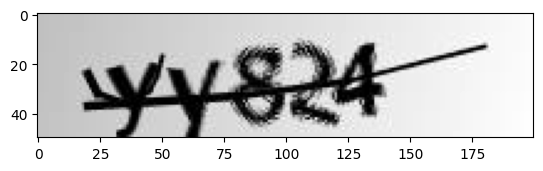

In [49]:
plot_predict('captcha_dataset/samples/yy824.png')

1/1 [==============================] - 0s 14ms/step
6gpgf


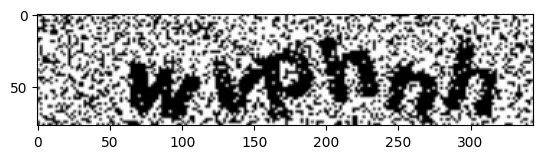

In [50]:
plot_predict('captcha_dataset/test/Screenshot from 2024-04-02 17-27-14.png')